# Image exploration and analysis

<img height="240" src="../Graphics/EDA/sample 744.png" width="240"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
from utils import ImageDataset, split_data, read_metrics, save_metrics
import tensorflow as tf
import json
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

Main module did not execute


### Read images and metadata

In [2]:
imagepath = r'C:\Users\dimka\Documents\Dermoscopy_Dataset\datasets\All BCC'
savepath = "/"

labels = pd.read_csv('labels.csv', index_col=0)
oh_labels = pd.read_csv('one_hot_labels.csv', index_col=0)
labels.sample(10)

,0
364,1
235,1
837,0
253,0
204,0
176,1
297,0
246,0
583,0
434,1


### Check the number of samples in each class

### Add the images to the dataframe

In [3]:
def str_to_numb(string_list):
    """

    :param x: list with of all the numbers
    :return: numbers missing
    """
    number_list = []
    for string in string_list:
        number = re.findall(r'\d+', string)
        number_list.append(int(number[0].strip()))
    # number_list.sort()
    return number_list

def check_for_missing_values(file_list, **kwargs):

    entries = str_to_numb(file_list)

    if 'length' in kwargs.keys:
        diff = len(entries) - kwargs['length']
    elif 'data' in kwargs.keys():
        diff = len(entries) - len(kwargs['data'])
    else:
        raise TypeError(f"At least one of 'length' or 'data' arguments must be passed")

    if diff < 0:
        print(f"There are {-diff} files missing")
    elif diff > 0:
        print(f"There are {diff} files with missing data")
    else:
        print("No files/values are missing")
        exit()

    j=0
    missing_values = []
    for entry in entries:
        if entry != (j + 1):
            missing_locally = abs(entry - (j+1))
            missing_values.append(range(missing_locally))
            j += missing_locally
        j += 1

    print(f"The")


entries = os.listdir(imagepath)
entries.sort(key=len)
img_numbers = str_to_numb(entries)
img_paths = []
j = 0
gegen = j + 1
for entry in entries:
    if img_numbers[j] == gegen:
        img_paths.append(os.path.join(imagepath, entry))
        gegen += 1
    else:
        print(f"Warning: picture {j + 1} is missing from the dataset")
        img_paths.append('None')
        img_paths.append(os.path.join(imagepath, entry))
        gegen += 2
    j += 1

df = pd.DataFrame()
df['Image Paths'] = img_paths


In [4]:
images = df['Image Paths'].values
random_images = [np.random.choice(images) for i in range(9)]

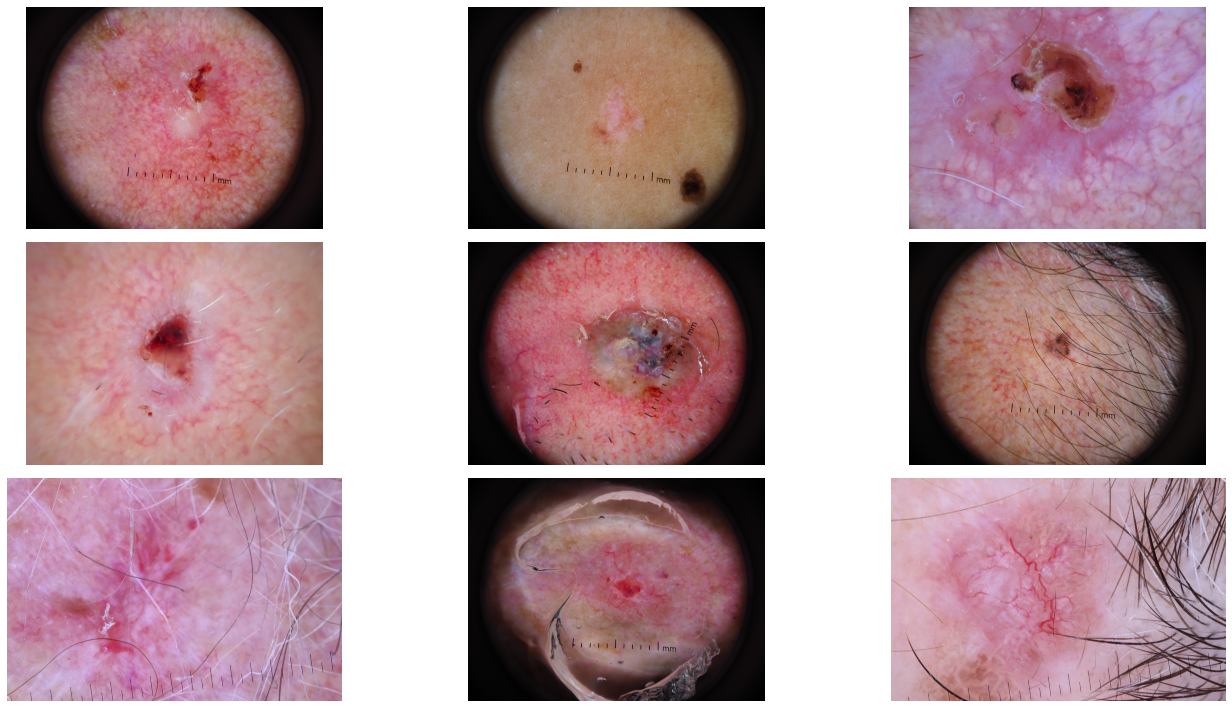

In [5]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(random_images[i])
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 3312 pixels width and 4416 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 139.1953 and the standard deviation is 31.1355


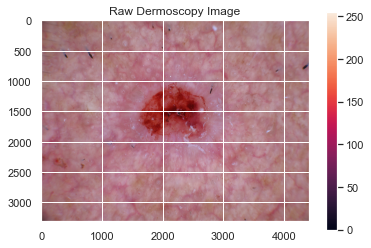

In [6]:
sample_img = df['Image Paths'][0]
raw_image = plt.imread(sample_img)
plt.imshow(raw_image)
plt.colorbar()
plt.title('Raw Dermoscopy Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

G:\My Drive\Libraries\Python\Environment\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

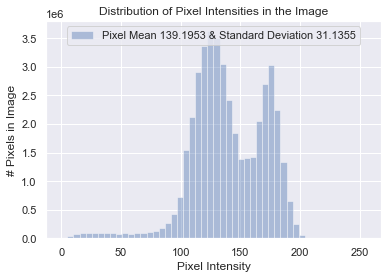

In [7]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(),
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [8]:
IMG_SHAPE = (224, 224, 3)
CLASS_NUMBER = 3
TEST_SET_SIZE = 10
OUTER_SPLITS = 842//TEST_SET_SIZE
INNER_SPLITS = 5
BATCH_SIZE = 64
LR = 1e-5

In [58]:

base_model = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)
base_model.trainable = False

In [10]:
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [12]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  515


In [11]:
#Fine-tune from this layer onwards
fine_tune_at = 450

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [12]:
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [60]:
history = []
base_savepath = "Models/StratifiedKFold/ResNet152"
experiment = 1
savepath = base_savepath + f"Experiment {experiment}/"

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              min_delta=1e-2,
                                              patience=7,
                                              verbose=1),
             tf.keras.callbacks.ModelCheckpoint(savepath,
                                      save_best_only=True,
                                      verbose=0,
                                      save_weights_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                  factor=0.1,
                                                  patience=5,
                                                  min_delta=1e-2)
            ]

metrics = ['categorical_accuracy', 'Precision', 'Recall', 'AUC']

data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
                                         tf.keras.layers.RandomRotation(0.1),
                                         tf.keras.layers.RandomZoom(0.1),])

outer_skf = split_data(df, labels, split_strategy='StratifiedKFold', n_splits=OUTER_SPLITS, shuffle=True, random_state=1369)

preprocess_input = tf.keras.applications.resnet.preprocess_input

with tf.device("gpu:0"):
    for (train_idx, test_idx), i in outer_skf:
        
        print(f"Starting Training on Fold {i+1}/{NUM_SPLITS}")
        print("===========================================")
        train = ImageDataset(imagepath, entries=images[train_idx], labels=oh_labels.loc[train_idx, :], image_type='jpg', search_type='*')
        test = ImageDataset(imagepath, entries=images[test_idx], labels=oh_labels.loc[test_idx, :], image_type='jpg', search_type='*')


        train = train.create_image_dataset()
        test = test.create_image_dataset()

        train = ImageDataset.performance_config(train, cache=True, batch_size=BATCH_SIZE, prefetch=True)
        test = ImageDataset.performance_config(test, cache=True, batch_size=BATCH_SIZE, prefetch=True)

        image_batch, label_batch = next(iter(train))
        feature_batch = base_model(image_batch)
        # print(feature_batch.shape)
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        feature_batch_average = global_average_layer(feature_batch)

        # print("Reached model definition")
        inputs = tf.keras.Input(shape=IMG_SHAPE)
        x = preprocess_input(inputs)
        x = data_augmentation(x)
        x = base_model(x, training=False)
        x = global_average_layer(x)
        # x = tf.keras.layers.Flatten(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        # print('Reached Compile')
        base_learning_rate = LR
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=metrics)
        # print('Reached Training')

        experiment, _ = read_metrics(base_savepath + 'results.xlsx')

        savepath = base_savepath + f"Experiment {experiment}/"

        fold_hist = model.fit(train,
                              epochs=100,
                              validation_data=test,
                              callbacks=callbacks)

        fold_metrics = [np.amax(fold_hist.history["val_" + metric.lower()]) for metric in metrics]

        save_metrics(base_savepath + 'results.xlsx', metrics=fold_metrics, labels=metrics)

        history.append(fold_hist)

Starting Training on Fold 1/5
Epoch 1/100
11/11 [==============================] - 14s 759ms/step - loss: 1.0773 - categorical_accuracy: 0.4829 - precision: 0.5080 - recall: 0.4250 - auc: 0.6917 - val_loss: 0.9365 - val_categorical_accuracy: 0.5858 - val_precision: 0.5915 - val_recall: 0.4970 - val_auc: 0.7538 - lr: 1.0000e-05
Epoch 2/100
11/11 [==============================] - 4s 409ms/step - loss: 0.9718 - categorical_accuracy: 0.5156 - precision: 0.5357 - recall: 0.4458 - auc: 0.7348 - val_loss: 0.8367 - val_categorical_accuracy: 0.6272 - val_precision: 0.6621 - val_recall: 0.5680 - val_auc: 0.8000 - lr: 1.0000e-05
Epoch 3/100
11/11 [==============================] - 4s 402ms/step - loss: 0.8943 - categorical_accuracy: 0.5750 - precision: 0.6079 - recall: 0.5230 - auc: 0.7775 - val_loss: 0.7476 - val_categorical_accuracy: 0.6805 - val_precision: 0.7181 - val_recall: 0.6331 - val_auc: 0.8384 - lr: 1.0000e-05
Epoch 4/100
11/11 [==============================] - 4s 401ms/step - loss: 

In [15]:

for fold in range(NUM_SPLITS):
    json.dump(history[fold].history, open(base_savepath + f"Fold_{fold}.json", 'w'))

TypeError: Object of type float32 is not JSON serializable

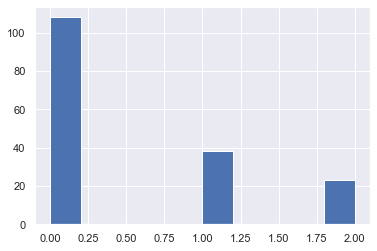

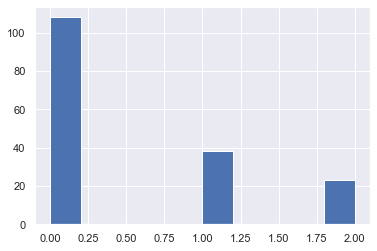

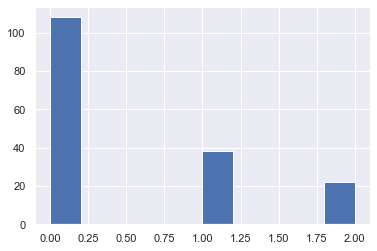

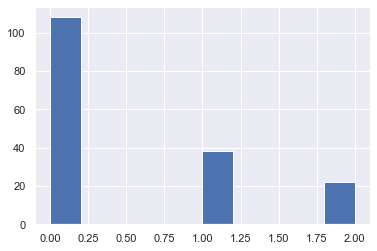

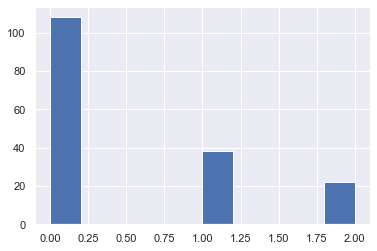

In [28]:
zkf = split_data(df, labels, split_strategy='StratifiedKFold', n_splits=NUM_SPLITS, shuffle=True, random_state=1369)
for (train_idx, test_idx), i in zkf:
    plt.figure()
    plt.hist(labels.to_numpy()[test_idx])

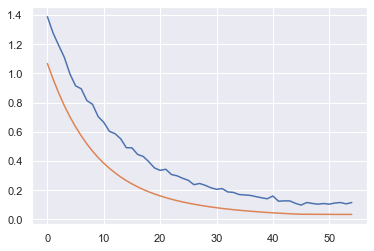

In [17]:
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])

In [44]:
def unpack_metrics(filepath, number_of_splits):

    loss = []
    val_loss = []
    acc = []
    val_acc = []
    val_auc = []
    val_recall = []
    val_precision = []
    val_f1 = []


    for fold in range(number_of_splits):

        with open(filepath + f"Fold_{fold}.json") as f:

            history = json.load(f)

            loss.append(history['loss'])
            val_loss.append(history['val_loss'])
            acc.append(history['categorical_accuracy'])
            val_acc.append(history['val_categorical_accuracy'])
            val_auc.append(history['val_auc'])
            val_recall.append(history['val_recall'])
            val_precision.append(history['val_precision'])
            val_f1.append(2 * np.array(val_precision[fold]) * np.array(val_recall[fold]) / np.array((val_precision[fold]) + np.array(val_recall[fold])))

    return {'loss':loss, 'val_loss':val_loss, 'acc':acc, 'val_acc':val_acc, 'val_auc':val_auc, 'val_recall':val_recall, 'val_precision':val_precision, 'val_f1':val_f1}


In [46]:
filepath = "G:/My Drive/Education/MSc Biomedical Engineering/Thesis/Code/Models/StratifiedKFold/ResNet152 with ImageNet weights/"
hist = unpack_metrics(filepath, NUM_SPLITS)

G:\My Drive\Libraries\Python\Environment\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

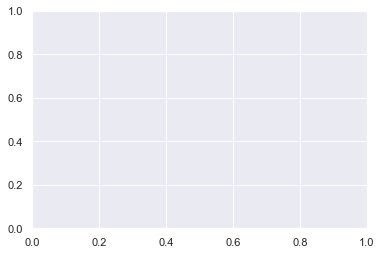

In [25]:
plt.plot(hist['loss'])

In [52]:
def plots(hist):
    fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(20, 20),
                            constrained_layout=True)

    for fold in range(NUM_SPLITS):
        loss, = axs[0,fold].plot(hist['loss'][fold])
        val_loss, = axs[0,fold].plot(hist['val_loss'][fold])
        axs[0,fold].set_title(f'Loss curves on Fold {fold+1}')
        axs[0,fold].set_xlabel('Epoch')
        axs[0,fold].legend([loss, val_loss], ['train loss', 'val loss'] )

        acc, = axs[1,fold].plot(hist['acc'][fold])
        val_acc, = axs[1,fold].plot(hist['val_acc'][fold])
        axs[1,fold].set_title(f'Accuracy on Fold {fold+1}')
        axs[1,fold].set_xlabel('Epoch')
        axs[1,fold].legend([acc, val_acc], ['train accuracy', 'val accuracy'])

        auc, = axs[2,fold].plot(hist['val_auc'][fold])
        axs[2,fold].set_title(f'AUC on Fold {fold+1}')
        axs[2,fold].set_xlabel('Epoch')

        precision, = axs[3,fold].plot(hist['val_precision'][fold])
        axs[3,fold].set_title(f'Precision on Fold {fold+1}')
        axs[3,fold].set_xlabel('Epoch')

        recall, = axs[4,fold].plot(hist['val_recall'][fold])
        axs[4,fold].set_title(f'Recall on Fold {fold+1}')
        axs[4,fold].set_xlabel('Epoch')

        f1, = axs[5,fold].plot(hist['val_f1'][fold])
        axs[5,fold].set_title(f'F1 score on Fold {fold+1}')
        axs[5,fold].set_xlabel('Epoch')

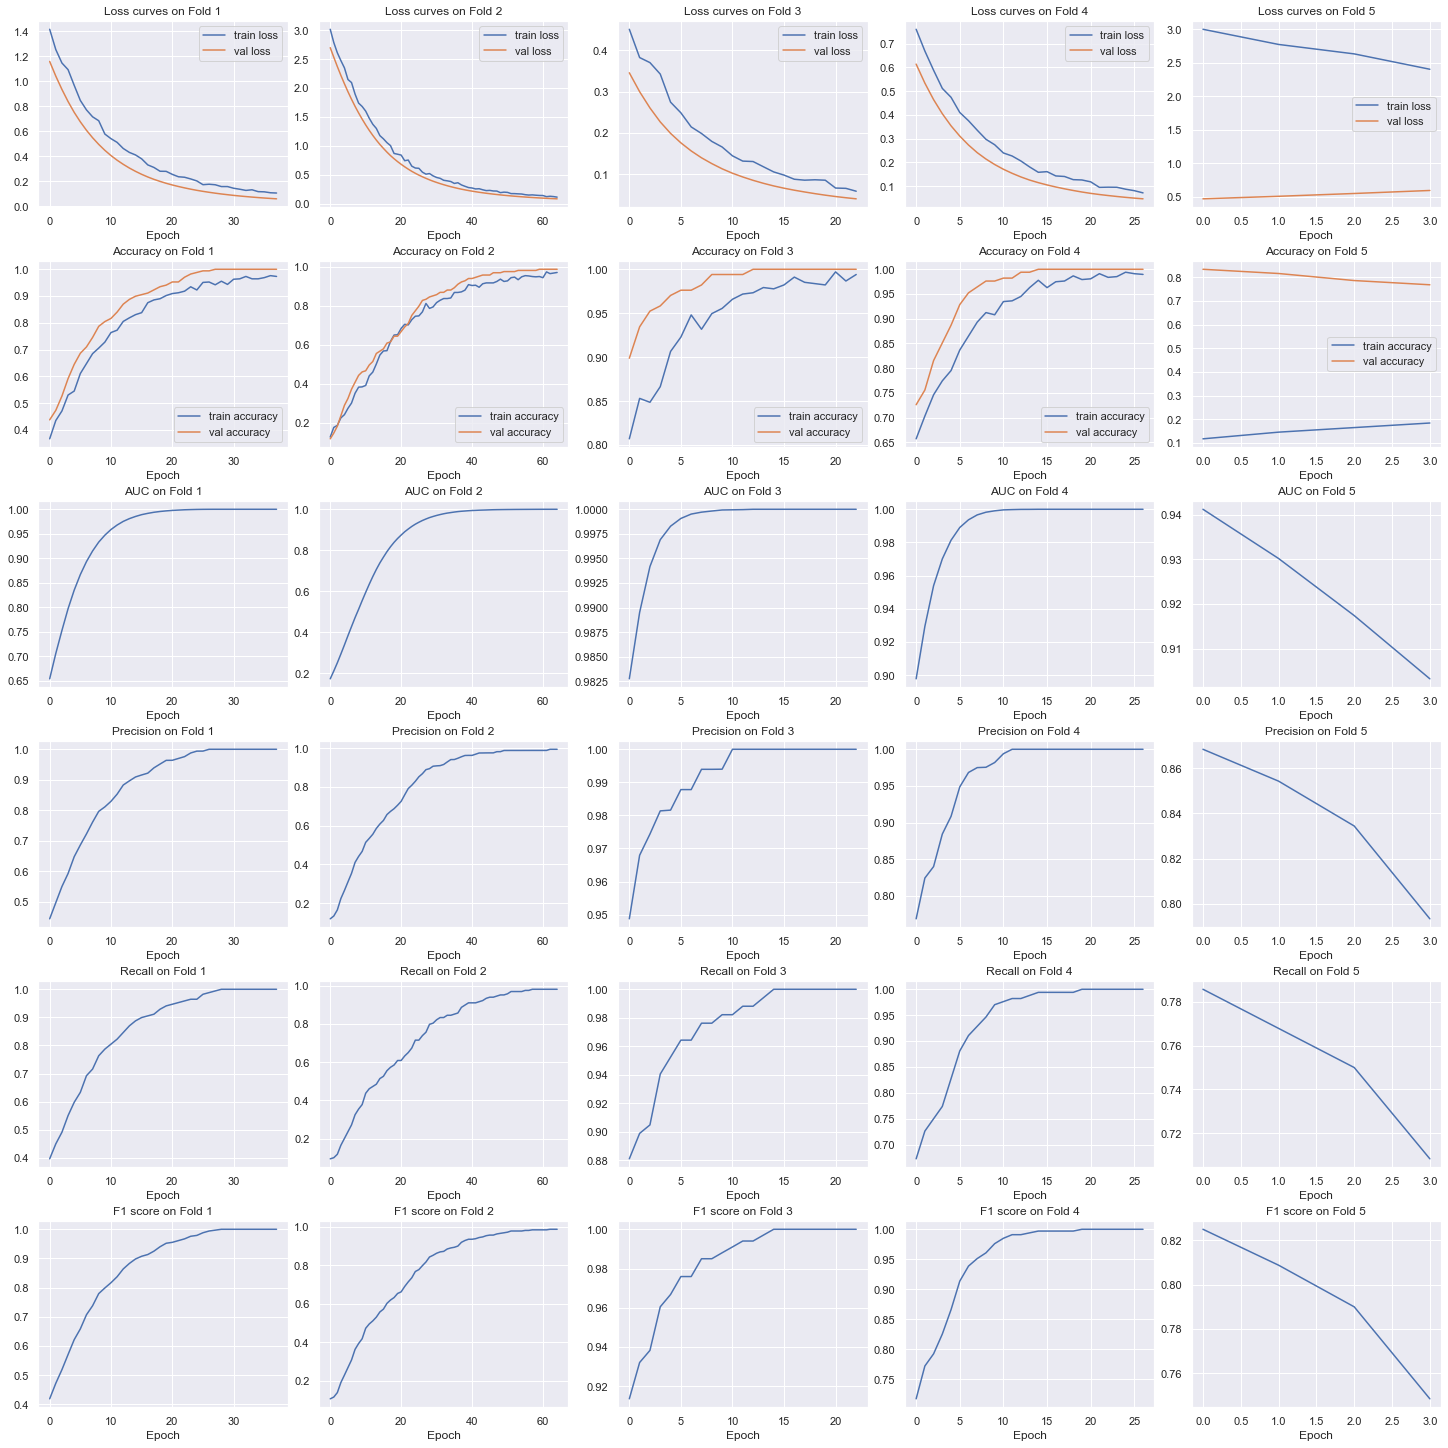

In [53]:
filepath = "G:/My Drive/Education/MSc Biomedical Engineering/Thesis/Code/Models/StratifiedKFold/ResNet152 with ImageNet weights/"
hist = unpack_metrics(filepath, NUM_SPLITS)
plots(hist)

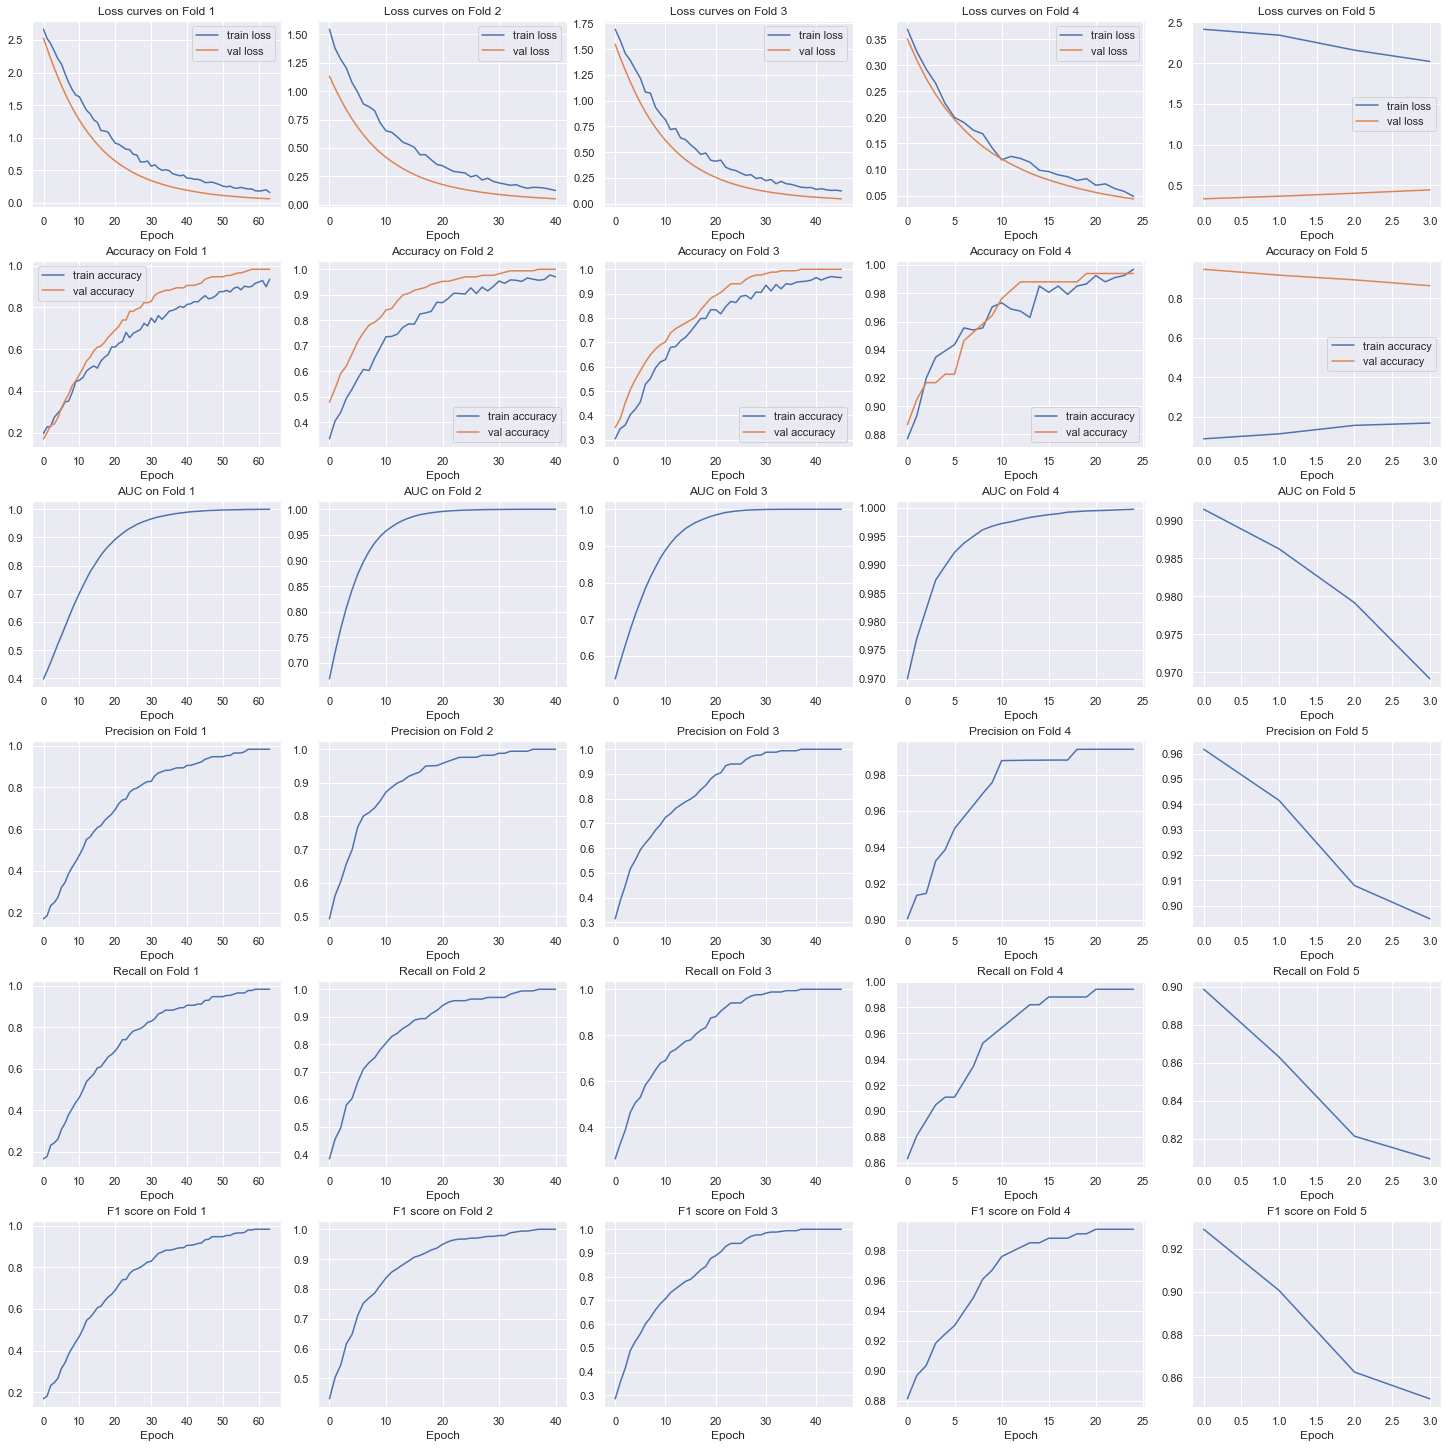

In [54]:
filepath1 = "G:/My Drive/Education/MSc Biomedical Engineering/Thesis/Code/Models/StratifiedKFold/ResNet152 with ImageNet weights and Augmentation/"
hist1 = unpack_metrics(filepath1, NUM_SPLITS)
plots(hist1)

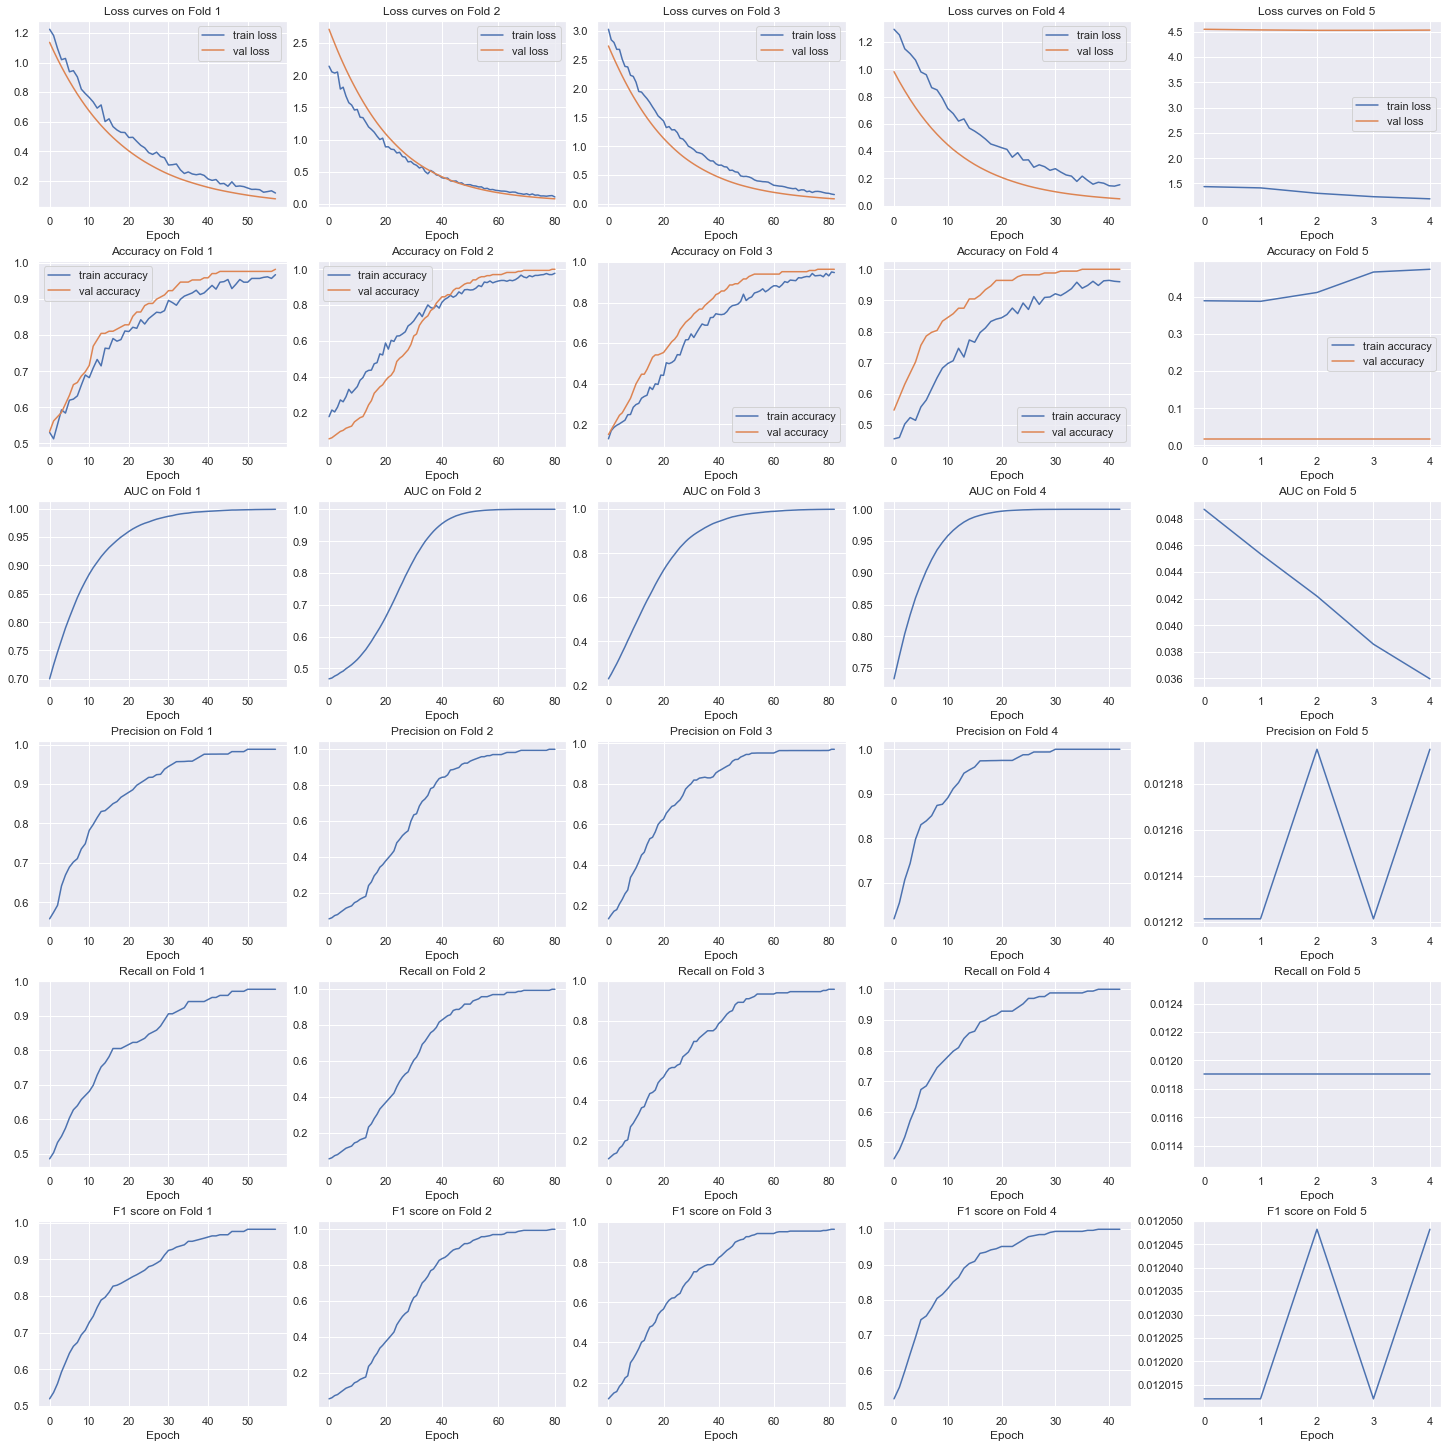

In [56]:


filepath2 = "G:/My Drive/Education/MSc Biomedical Engineering/Thesis/Code/Models/StratifiedKFold/ResNet152 - Training Last 65 layers/"
hist2 = unpack_metrics(filepath2, NUM_SPLITS)
plots(hist2)